#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임 워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [40]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈

import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [41]:
# 랜덤 시드 고정
torch.manual_seed(1)

In [42]:
# 데이터 로딩 : CSV = > DataFrame
DATA_FILE='iris.csv'

irisDF=pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 - 회귀
- 알고리즘 : 선형관계 - 선형모델 => nn.Linear

In [43]:
# in_features : petal.length, sepal.length, sepal.width 3개
# out_features : petal.width 1개
model = nn.Linear(3, 1)

In [44]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True)

[bias] Parameter containing:
tensor([0.2710], requires_grad=True)



[3] 최적화 인스턴스 준비

In [45]:
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

[4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [46]:
featureTS=torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [47]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [48]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS, test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(f'[Feature] Train {X_train.shape}, TEST { X_test.shape}, VAL {X_val.shape}')
print(f'[Target] Train {y_train.shape}, TEST { y_test.shape}, VAL {y_val.shape}')

[Feature] Train torch.Size([96, 3]), TEST torch.Size([30, 3]), VAL torch.Size([24, 3])
[Target] Train torch.Size([96, 1]), TEST torch.Size([30, 1]), VAL torch.Size([24, 1])


[4-2] 학습진행  
    * 학습횟수 결정 ==> 에포크 설정  
    * 학습결과 저장 ==> 손실저장 변수 

In [49]:
EPOCH=10
loss_history=[]

In [50]:
# for epoch in range(EPOCH):
#     #-(1)학습진행 - forward
#     pre_y=model(featureTS)
#     #-(2)오차계산 - 손실함수
#     loss=F.mse_loss(pre_y, targetTS)
#     #-(3)최적화 - 가중치,절편 업데이트 backward
#     adam_optim.zero_grad() #gradient를 0으로 초기화
#     loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
#     adam_optim.step() #  가중치 업데이트 W와 b를 업데이트

#     #-(4)학습결과 출력 및 저장
#     print(f'[{epoch}/{EPOCH}] LOSS: {loss}')

## 함수로만들기

In [51]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testTS,targetTS, kind='Val'):

    with torch.no_grad():    # 가중치 및 절편 업데이트 진행 X
        #-(1)학습진행 - forward
        pre_y=model(testTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
 
        #-(4)학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}')

    return loss

In [52]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history=[[],[]]
    for epoch in range(EPOCH):
        #-(1)학습진행 - forward
        pre_y=model(featureTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())
        
        #-(3)최적화 - 가중치,절편 업데이트 backward
        adam_optim.zero_grad() #gradient를 0으로 초기화
        loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
        adam_optim.step() #  가중치 업데이트 W와 b를 업데이트

        #-(4)검증 - 모댈이 제대로 만들어지는 검사용
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        #-(4)학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS: {loss}')

    return loss_history

In [54]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val)

[Val] LOSS: 1.28097403049469
[0/10] LOSS: 0.7419636845588684
[Val] LOSS: 0.7328507304191589
[1/10] LOSS: 1.120179533958435
[Val] LOSS: 0.3353336751461029
[2/10] LOSS: 0.6362813115119934
[Val] LOSS: 0.48521819710731506
[3/10] LOSS: 0.35211876034736633
[Val] LOSS: 0.45762911438941956
[4/10] LOSS: 0.585462749004364
[Val] LOSS: 0.24948160350322723
[5/10] LOSS: 0.5573251843452454
[Val] LOSS: 0.20552052557468414
[6/10] LOSS: 0.30203333497047424
[Val] LOSS: 0.32875481247901917
[7/10] LOSS: 0.21323604881763458
[Val] LOSS: 0.35012087225914
[8/10] LOSS: 0.31856146454811096
[Val] LOSS: 0.21343602240085602
[9/10] LOSS: 0.34534814953804016


In [55]:
loss

[[0.7419636845588684,
  1.120179533958435,
  0.6362813115119934,
  0.35211876034736633,
  0.585462749004364,
  0.5573251843452454,
  0.30203333497047424,
  0.21323604881763458,
  0.31856146454811096,
  0.34534814953804016],
 [1.28097403049469,
  0.7328507304191589,
  0.3353336751461029,
  0.48521819710731506,
  0.45762911438941956,
  0.24948160350322723,
  0.20552052557468414,
  0.32875481247901917,
  0.35012087225914,
  0.21343602240085602]]

In [60]:
testing(X_test, y_test)

[Val] LOSS: 0.2924749255180359


tensor(0.2925)

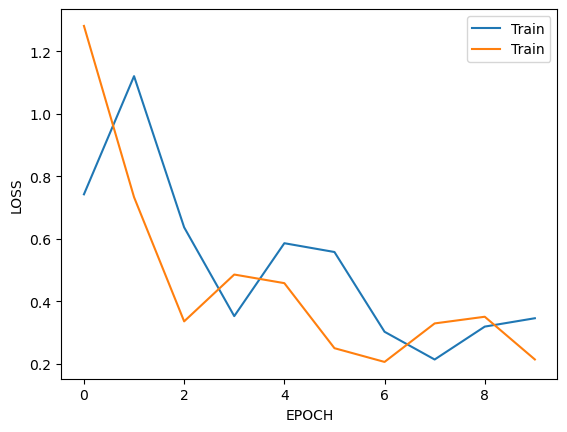

In [63]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(EPOCH),loss[0], label = 'Train')
plt.plot(range(EPOCH),loss[1], label='Train')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.show()